In [4]:
!git add .


^C


In [4]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
# 1. 이미지 경로 및 레이블 리스트 생성
base_dir_original = 'Training'  # 데이터가 저장된 기본 경로
image_paths = []
labels = []

for folder_name in os.listdir(base_dir_original):
    folder_path = os.path.join(base_dir_original, folder_name)
    if os.path.isdir(folder_path):
        # 레이블 추출: 폴더 이름에서 정보 파싱
        label = folder_name.split(']')[-1].split('_')[0]
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if image_path.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(image_path)
                labels.append(label)
unique_labels = sorted(set(labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
labels = [label_to_index[label] for label in labels]

In [5]:
# train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42
)

# 3. 이미지 로드 및 전처리 함수 정의
def preprocess_image(image_path, label, target_height=128, target_width=128):
    # 이미지 읽기
    image = tf.io.read_file(image_path)
    # 이미지 디코딩 및 리사이징
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, target_height, target_width)
    # 픽셀 값을 0~1로 정규화
    image = image / 255.0
    return image, label

# 4. TensorFlow 데이터 파이프라인 생성
def create_dataset(image_paths, labels, batch_size=32, target_height=128, target_width=128):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    # 데이터셋 전처리 매핑
    dataset = dataset.map(lambda path, label: preprocess_image(path, label, target_height, target_width),
                          num_parallel_calls=tf.data.AUTOTUNE)
    # 데이터 셔플 및 배치
    dataset = dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [10]:
# 5. 학습 및 테스트 데이터셋 생성
batch_size = 32
train_dataset = create_dataset(train_paths, train_labels, batch_size)
test_dataset = create_dataset(test_paths, test_labels, batch_size)

In [11]:
import tensorflow as tf

model10 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),  # 드롭아웃 추가

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),  # 드롭아웃 추가

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),  # 드롭아웃 추가

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 추가

    tf.keras.layers.Dense(7, activation='softmax'),  # Softmax로 변경
])




In [12]:
model10.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 30, 30, 64)       

In [13]:
# Early Stopping 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',       # 검증 손실(val_loss)을 모니터링
    patience=5,               # 개선되지 않는 epoch 5번 이후 학습 종료
    restore_best_weights=True # 가장 성능 좋은 가중치를 복원
)

In [14]:

# 모델 컴파일
model10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
result10 =model10.fit(train_dataset, validation_data=test_dataset, epochs=50, callbacks=[early_stopping],)

Epoch 1/50


2024-12-04 08:47:51.809365: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-04 08:48:01.932738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1512 of 10508
2024-12-04 08:48:11.921327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3063 of 10508
2024-12-04 08:48:21.919293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4564 of 10508
2024-12-04 08:48:31.918501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6123 of 10508
2024-12-04 08:48:41.922789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may tak

329/329 [==============================] - ETA: 0s - loss: 1.8554 - accuracy: 0.2453

2024-12-04 08:49:14.786677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1531 of 4504
2024-12-04 08:49:24.784980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3075 of 4504
2024-12-04 08:49:33.963022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 103s 99ms/step - loss: 1.8554 - accuracy: 0.2453 - val_loss: 1.7367 - val_accuracy: 0.3175
Epoch 2/50


2024-12-04 08:50:23.832354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1822 of 10508
2024-12-04 08:50:33.828932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3730 of 10508
2024-12-04 08:50:43.832241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5556 of 10508
2024-12-04 08:50:53.834739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7401 of 10508
2024-12-04 08:51:03.828564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9279 of 10508


 24/329 [=>............................] - ETA: 2s - loss: 1.7353 - accuracy: 0.2995 

2024-12-04 08:51:10.293348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.7153 - accuracy: 0.3106

2024-12-04 08:51:22.722142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1880 of 4504
2024-12-04 08:51:32.724991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3727 of 4504
2024-12-04 08:51:37.028716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 84s 83ms/step - loss: 1.7153 - accuracy: 0.3106 - val_loss: 1.6406 - val_accuracy: 0.3777
Epoch 3/50


2024-12-04 08:51:47.560700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1875 of 10508
2024-12-04 08:51:57.562033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3778 of 10508
2024-12-04 08:52:07.561685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5630 of 10508
2024-12-04 08:52:17.562559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7449 of 10508
2024-12-04 08:52:27.564134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9351 of 10508


 25/329 [=>............................] - ETA: 2s - loss: 1.6724 - accuracy: 0.3475 

2024-12-04 08:52:33.726960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.6475 - accuracy: 0.3455

2024-12-04 08:52:46.104668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1862 of 4504
2024-12-04 08:52:56.120759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3722 of 4504
2024-12-04 08:53:00.514500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 83s 83ms/step - loss: 1.6475 - accuracy: 0.3455 - val_loss: 1.5536 - val_accuracy: 0.4214
Epoch 4/50


2024-12-04 08:53:11.033765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1804 of 10508
2024-12-04 08:53:21.033471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3659 of 10508
2024-12-04 08:53:31.034582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5511 of 10508
2024-12-04 08:53:41.035010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7340 of 10508
2024-12-04 08:53:51.036356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9234 of 10508


 25/329 [=>............................] - ETA: 2s - loss: 1.5634 - accuracy: 0.3625 

2024-12-04 08:53:57.848628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.5734 - accuracy: 0.3849

2024-12-04 08:54:10.229138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1860 of 4504
2024-12-04 08:54:20.222472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3701 of 4504
2024-12-04 08:54:24.868322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 84s 84ms/step - loss: 1.5734 - accuracy: 0.3846 - val_loss: 1.5083 - val_accuracy: 0.4365
Epoch 5/50


2024-12-04 08:54:35.397557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1781 of 10508
2024-12-04 08:54:45.386689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3652 of 10508
2024-12-04 08:54:55.393653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5458 of 10508
2024-12-04 08:55:05.389604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7268 of 10508
2024-12-04 08:55:15.388704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9119 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.5347 - accuracy: 0.4293 

2024-12-04 08:55:22.964824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.5282 - accuracy: 0.4186

2024-12-04 08:55:35.281558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1791 of 4504
2024-12-04 08:55:45.282284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3622 of 4504
2024-12-04 08:55:50.402741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 86s 85ms/step - loss: 1.5267 - accuracy: 0.4194 - val_loss: 1.4096 - val_accuracy: 0.4660
Epoch 6/50


2024-12-04 08:56:00.910911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1757 of 10508
2024-12-04 08:56:10.906410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3532 of 10508
2024-12-04 08:56:20.905302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5273 of 10508
2024-12-04 08:56:30.908613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7058 of 10508
2024-12-04 08:56:40.904283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8815 of 10508


 24/329 [=>............................] - ETA: 2s - loss: 1.4470 - accuracy: 0.4531 

2024-12-04 08:56:50.220830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.4723 - accuracy: 0.4412

2024-12-04 08:57:02.516023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1793 of 4504
2024-12-04 08:57:12.518522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3604 of 4504
2024-12-04 08:57:17.903126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 86ms/step - loss: 1.4709 - accuracy: 0.4417 - val_loss: 1.4085 - val_accuracy: 0.4831
Epoch 7/50


2024-12-04 08:57:28.417968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1711 of 10508
2024-12-04 08:57:38.410214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3501 of 10508
2024-12-04 08:57:48.409960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5225 of 10508
2024-12-04 08:57:58.409765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6961 of 10508
2024-12-04 08:58:08.413031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8703 of 10508


  9/329 [..............................] - ETA: 2s - loss: 1.4577 - accuracy: 0.3889     

2024-12-04 08:58:18.411106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10485 of 10508
2024-12-04 08:58:18.536014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


323/329 [============================>.] - ETA: 0s - loss: 1.4138 - accuracy: 0.4708

2024-12-04 08:58:30.963130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1765 of 4504
2024-12-04 08:58:40.966901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3526 of 4504
2024-12-04 08:58:47.054704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 89s 88ms/step - loss: 1.4141 - accuracy: 0.4701 - val_loss: 1.3378 - val_accuracy: 0.5056
Epoch 8/50


2024-12-04 08:58:57.553186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1701 of 10508
2024-12-04 08:59:07.550819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3511 of 10508
2024-12-04 08:59:17.551623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5265 of 10508
2024-12-04 08:59:27.554800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6997 of 10508
2024-12-04 08:59:37.553119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8737 of 10508


  1/329 [..............................] - ETA: 5:29:12 - loss: 1.2710 - accuracy: 0.5312

2024-12-04 08:59:47.580676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10472 of 10508
2024-12-04 08:59:47.760414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.3587 - accuracy: 0.4950

2024-12-04 09:00:00.143657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1754 of 4504
2024-12-04 09:00:10.150284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3427 of 4504
2024-12-04 09:00:17.080996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 90s 91ms/step - loss: 1.3582 - accuracy: 0.4951 - val_loss: 1.4398 - val_accuracy: 0.4547
Epoch 9/50


2024-12-04 09:00:27.566668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1657 of 10508
2024-12-04 09:00:37.572213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3449 of 10508
2024-12-04 09:00:47.572839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5074 of 10508
2024-12-04 09:00:57.597281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6685 of 10508
2024-12-04 09:01:07.573555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8377 of 10508
2024-12-04 09:01:17.569182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10071 of 10508


 24/329 [=>............................] - ETA: 2s - loss: 1.3279 - accuracy: 0.5039 

2024-12-04 09:01:20.036044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.3200 - accuracy: 0.5102

2024-12-04 09:01:32.350901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1670 of 4504
2024-12-04 09:01:42.341663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3437 of 4504
2024-12-04 09:01:48.797811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 92s 89ms/step - loss: 1.3211 - accuracy: 0.5096 - val_loss: 1.2498 - val_accuracy: 0.5420
Epoch 10/50


2024-12-04 09:01:59.307085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1697 of 10508
2024-12-04 09:02:09.310828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3449 of 10508
2024-12-04 09:02:19.309119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5173 of 10508
2024-12-04 09:02:29.304907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6847 of 10508
2024-12-04 09:02:39.308236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8552 of 10508
2024-12-04 09:02:49.311503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10290 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 1.2148 - accuracy: 0.5767 

2024-12-04 09:02:50.505804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.2805 - accuracy: 0.5279

2024-12-04 09:03:02.897929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1743 of 4504
2024-12-04 09:03:12.897547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3444 of 4504
2024-12-04 09:03:19.302873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 90s 89ms/step - loss: 1.2795 - accuracy: 0.5284 - val_loss: 1.2783 - val_accuracy: 0.5286
Epoch 11/50


2024-12-04 09:03:29.793276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1794 of 10508
2024-12-04 09:03:39.798188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3635 of 10508
2024-12-04 09:03:49.795989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5431 of 10508
2024-12-04 09:03:59.840596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7197 of 10508
2024-12-04 09:04:09.797634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9036 of 10508


 24/329 [=>............................] - ETA: 2s - loss: 1.1396 - accuracy: 0.5846 

2024-12-04 09:04:17.766387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


324/329 [============================>.] - ETA: 0s - loss: 1.2204 - accuracy: 0.5504

2024-12-04 09:04:30.106197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1856 of 4504
2024-12-04 09:04:40.130990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3722 of 4504
2024-12-04 09:04:44.442209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 85s 83ms/step - loss: 1.2209 - accuracy: 0.5506 - val_loss: 1.2070 - val_accuracy: 0.5673
Epoch 12/50


2024-12-04 09:04:54.935786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1880 of 10508
2024-12-04 09:05:04.940329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3775 of 10508
2024-12-04 09:05:14.942591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5640 of 10508
2024-12-04 09:05:24.940150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7500 of 10508
2024-12-04 09:05:34.940256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9351 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.1775 - accuracy: 0.5639 

2024-12-04 09:05:41.044748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.1653 - accuracy: 0.5741

2024-12-04 09:05:53.386048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1898 of 4504
2024-12-04 09:06:03.382020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3786 of 4504
2024-12-04 09:06:07.416588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 83s 82ms/step - loss: 1.1659 - accuracy: 0.5738 - val_loss: 1.2087 - val_accuracy: 0.5619
Epoch 13/50


2024-12-04 09:06:17.891326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1870 of 10508
2024-12-04 09:06:27.901363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3783 of 10508
2024-12-04 09:06:37.896213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5640 of 10508
2024-12-04 09:06:47.895736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7498 of 10508
2024-12-04 09:06:57.897291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9401 of 10508


 25/329 [=>............................] - ETA: 2s - loss: 1.1219 - accuracy: 0.5925 

2024-12-04 09:07:03.702447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.1365 - accuracy: 0.5850

2024-12-04 09:07:16.051543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1865 of 4504
2024-12-04 09:07:26.049882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3763 of 4504
2024-12-04 09:07:30.033050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 83s 82ms/step - loss: 1.1376 - accuracy: 0.5849 - val_loss: 1.2081 - val_accuracy: 0.5584
Epoch 14/50


2024-12-04 09:07:40.542244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1895 of 10508
2024-12-04 09:07:50.543007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3814 of 10508
2024-12-04 09:08:00.539541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5683 of 10508
2024-12-04 09:08:10.540531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7541 of 10508
2024-12-04 09:08:20.541971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9448 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.0603 - accuracy: 0.6087 

2024-12-04 09:08:26.105763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.0874 - accuracy: 0.5994

2024-12-04 09:08:38.528326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1889 of 4504
2024-12-04 09:08:48.523557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3797 of 4504
2024-12-04 09:08:52.424607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 82s 82ms/step - loss: 1.0874 - accuracy: 0.5994 - val_loss: 1.1764 - val_accuracy: 0.5748
Epoch 15/50


2024-12-04 09:09:02.924676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1887 of 10508
2024-12-04 09:09:12.928285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3810 of 10508
2024-12-04 09:09:22.927799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5663 of 10508
2024-12-04 09:09:32.931259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7528 of 10508
2024-12-04 09:09:42.928163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9448 of 10508


 25/329 [=>............................] - ETA: 1s - loss: 1.0249 - accuracy: 0.6212 

2024-12-04 09:09:48.476754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


322/329 [============================>.] - ETA: 0s - loss: 1.0409 - accuracy: 0.6112

2024-12-04 09:10:00.828673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1886 of 4504
2024-12-04 09:10:10.828190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3780 of 4504
2024-12-04 09:10:15.061359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 83s 83ms/step - loss: 1.0423 - accuracy: 0.6102 - val_loss: 1.1996 - val_accuracy: 0.5702
Epoch 16/50


2024-12-04 09:10:25.578462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1856 of 10508
2024-12-04 09:10:35.576259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3744 of 10508
2024-12-04 09:10:45.583238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5588 of 10508
2024-12-04 09:10:55.570919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7429 of 10508
2024-12-04 09:11:05.574957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9343 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 1.0225 - accuracy: 0.6345 

2024-12-04 09:11:11.755824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.0092 - accuracy: 0.6261

2024-12-04 09:11:24.101150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1833 of 4504
2024-12-04 09:11:34.096221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3692 of 4504
2024-12-04 09:11:38.547409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 83s 83ms/step - loss: 1.0092 - accuracy: 0.6262 - val_loss: 1.2050 - val_accuracy: 0.5730
Epoch 17/50


2024-12-04 09:12:47.484729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1886 of 10508
2024-12-04 09:12:57.485756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3809 of 10508
2024-12-04 09:13:07.486839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5647 of 10508
2024-12-04 09:13:17.484718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7501 of 10508
2024-12-04 09:13:27.487448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9424 of 10508


 24/329 [=>............................] - ETA: 2s - loss: 0.9646 - accuracy: 0.6510 

2024-12-04 09:13:33.224032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.9682 - accuracy: 0.6370

2024-12-04 09:13:45.451148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1894 of 4504
2024-12-04 09:13:55.444233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3797 of 4504
2024-12-04 09:13:59.249272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 82s 81ms/step - loss: 0.9682 - accuracy: 0.6370 - val_loss: 1.1735 - val_accuracy: 0.5817
Epoch 18/50


2024-12-04 09:14:09.740356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1895 of 10508
2024-12-04 09:14:19.741087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3816 of 10508
2024-12-04 09:14:29.740164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5680 of 10508
2024-12-04 09:14:39.739704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7500 of 10508
2024-12-04 09:14:49.743642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9377 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 0.9466 - accuracy: 0.6477 

2024-12-04 09:14:55.741444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


323/329 [============================>.] - ETA: 0s - loss: 0.9394 - accuracy: 0.6488

2024-12-04 09:15:08.065257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1878 of 4504
2024-12-04 09:15:18.060731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3773 of 4504
2024-12-04 09:15:22.006162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 83s 82ms/step - loss: 0.9396 - accuracy: 0.6496 - val_loss: 1.1981 - val_accuracy: 0.5886
Epoch 19/50


2024-12-04 09:15:32.501173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1897 of 10508
2024-12-04 09:15:42.505180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3809 of 10508
2024-12-04 09:15:52.505228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5697 of 10508
2024-12-04 09:16:02.501853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7527 of 10508
2024-12-04 09:16:12.501885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9448 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 0.9129 - accuracy: 0.6467 

2024-12-04 09:16:18.083035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 0.9150 - accuracy: 0.6606

2024-12-04 09:16:30.427330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1891 of 4504
2024-12-04 09:16:40.431571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3787 of 4504
2024-12-04 09:16:44.321012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 82s 81ms/step - loss: 0.9161 - accuracy: 0.6604 - val_loss: 1.1938 - val_accuracy: 0.5841
Epoch 20/50


2024-12-04 09:16:54.815074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1871 of 10508
2024-12-04 09:17:04.814774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3794 of 10508
2024-12-04 09:17:14.818785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5650 of 10508
2024-12-04 09:17:24.817274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7467 of 10508
2024-12-04 09:17:34.819064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9380 of 10508


 23/329 [=>............................] - ETA: 2s - loss: 0.8209 - accuracy: 0.7024 

2024-12-04 09:17:40.744244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


323/329 [============================>.] - ETA: 0s - loss: 0.8800 - accuracy: 0.6741

2024-12-04 09:17:53.097880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1876 of 4504
2024-12-04 09:18:03.101494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3783 of 4504
2024-12-04 09:18:06.972843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 83s 81ms/step - loss: 0.8810 - accuracy: 0.6738 - val_loss: 1.2112 - val_accuracy: 0.5901
Epoch 21/50


2024-12-04 09:18:17.460685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1881 of 10508
2024-12-04 09:18:27.463353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3787 of 10508
2024-12-04 09:18:37.468890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5637 of 10508
2024-12-04 09:18:47.461442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7472 of 10508
2024-12-04 09:18:57.465800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9380 of 10508


 25/329 [=>............................] - ETA: 1s - loss: 0.8021 - accuracy: 0.6925 

2024-12-04 09:19:03.477265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 0.8690 - accuracy: 0.6740

2024-12-04 09:19:15.804363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1889 of 4504
2024-12-04 09:19:25.804103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3736 of 4504
2024-12-04 09:19:29.933708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 83s 82ms/step - loss: 0.8689 - accuracy: 0.6737 - val_loss: 1.1855 - val_accuracy: 0.5864
Epoch 22/50


2024-12-04 09:19:40.421500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1885 of 10508
2024-12-04 09:19:50.430459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3808 of 10508
2024-12-04 09:20:00.425235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5661 of 10508
2024-12-04 09:20:10.427110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7476 of 10508
2024-12-04 09:20:20.423125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9390 of 10508


 25/329 [=>............................] - ETA: 2s - loss: 0.8075 - accuracy: 0.6837 

2024-12-04 09:20:26.253282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


322/329 [============================>.] - ETA: 0s - loss: 0.8261 - accuracy: 0.6910

2024-12-04 09:20:38.625213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1896 of 4504
2024-12-04 09:20:48.622890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3809 of 4504
2024-12-04 09:20:52.338858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 82s 81ms/step - loss: 0.8248 - accuracy: 0.6917 - val_loss: 1.1833 - val_accuracy: 0.6066


In [16]:
# 모델 평가
score10 = model10.evaluate(test_dataset)
score10

2024-12-04 09:51:51.465115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1880 of 4504
2024-12-04 09:52:01.483290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3777 of 4504


 22/141 [===>..........................] - ETA: 0s - loss: 1.1879 - accuracy: 0.5810

2024-12-04 09:52:05.367674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


141/141 [==============================] - 25s 7ms/step - loss: 1.1735 - accuracy: 0.5817


[1.1734678745269775, 0.5817051529884338]

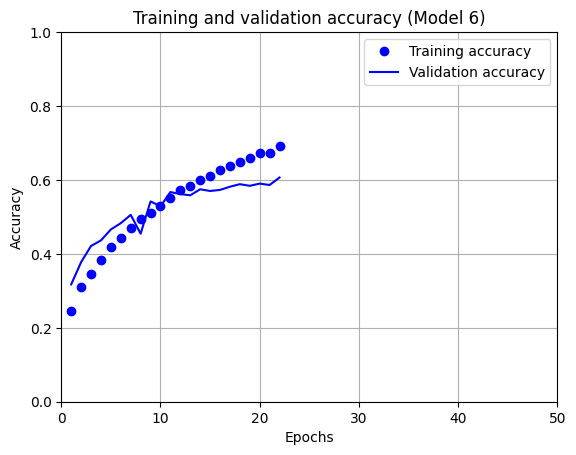

In [17]:
import matplotlib.pyplot as plt
acc10 = result10.history['accuracy']
val_acc10 = result10.history['val_accuracy']
loss10 = result10.history['loss']
val_loss10 = result10.history['val_loss']
epochs10 = range(1, len(acc10) + 1)

# Training and validation accuracy plot
plt.plot(epochs10, acc10, 'bo', label='Training accuracy')
plt.plot(epochs10, val_acc10, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (Model 6)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.ylim(0, 1)   # y축 범위 고정 (0 ~ 1)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()

# # Training and validation loss plot
# plt.plot(epochs10, loss10, 'bo', label='Training loss')
# plt.plot(epochs10, val_loss10, 'b', label='Validation loss')
# plt.title('Training and validation loss (Model 6)')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
# plt.legend()
# plt.grid()       # 그리드 추가 (선택 사항)
# plt.show()



In [18]:
result10 =model10.fit(train_dataset, validation_data=test_dataset, epochs=50)

Epoch 1/50


2024-12-04 09:55:34.018253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1885 of 10508
2024-12-04 09:55:44.022423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3801 of 10508
2024-12-04 09:55:54.019803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5665 of 10508
2024-12-04 09:56:04.023223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7514 of 10508
2024-12-04 09:56:14.023889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9384 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.9167 - accuracy: 0.6719 

2024-12-04 09:56:19.982708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 0.9179 - accuracy: 0.6603

2024-12-04 09:56:34.798531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1894 of 4504
2024-12-04 09:56:44.794100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3791 of 4504
2024-12-04 09:56:48.615091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 86s 90ms/step - loss: 0.9179 - accuracy: 0.6603 - val_loss: 1.1494 - val_accuracy: 0.5977
Epoch 2/50


2024-12-04 09:57:55.943617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1875 of 10508
2024-12-04 09:58:05.945617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3768 of 10508
2024-12-04 09:58:15.944459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5623 of 10508
2024-12-04 09:58:25.941809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7472 of 10508
2024-12-04 09:58:35.947934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9382 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.8621 - accuracy: 0.6629 

2024-12-04 09:58:41.854972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.8934 - accuracy: 0.6636

2024-12-04 09:58:56.935598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1893 of 4504
2024-12-04 09:59:06.939777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3777 of 4504
2024-12-04 09:59:10.822518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 86s 91ms/step - loss: 0.8934 - accuracy: 0.6636 - val_loss: 1.1774 - val_accuracy: 0.5895
Epoch 3/50


2024-12-04 09:59:21.825945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1888 of 10508
2024-12-04 09:59:31.821167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3812 of 10508
2024-12-04 09:59:41.823500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5676 of 10508
2024-12-04 09:59:51.821354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7533 of 10508
2024-12-04 10:00:01.818493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9449 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.7917 - accuracy: 0.7083 

2024-12-04 10:00:07.498230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.8562 - accuracy: 0.6801

2024-12-04 10:00:22.234393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1875 of 4504
2024-12-04 10:00:32.231016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3772 of 4504
2024-12-04 10:00:36.209827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 85s 90ms/step - loss: 0.8562 - accuracy: 0.6801 - val_loss: 1.2238 - val_accuracy: 0.5864
Epoch 4/50


2024-12-04 10:00:47.177626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1879 of 10508
2024-12-04 10:00:57.173514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3733 of 10508
2024-12-04 10:01:07.178001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5551 of 10508
2024-12-04 10:01:17.174928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7374 of 10508
2024-12-04 10:01:27.178172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9271 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.9126 - accuracy: 0.6646 

2024-12-04 10:01:33.708617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


324/329 [============================>.] - ETA: 0s - loss: 0.8564 - accuracy: 0.6780

2024-12-04 10:01:48.807121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1890 of 4504
2024-12-04 10:01:58.802573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3797 of 4504
2024-12-04 10:02:02.590214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 86s 91ms/step - loss: 0.8545 - accuracy: 0.6785 - val_loss: 1.1841 - val_accuracy: 0.6035
Epoch 5/50


2024-12-04 10:02:13.567781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1874 of 10508
2024-12-04 10:02:23.569390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3787 of 10508
2024-12-04 10:02:33.563807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5640 of 10508
2024-12-04 10:02:43.570721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7475 of 10508
2024-12-04 10:02:53.566194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9384 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.7267 - accuracy: 0.7292 

2024-12-04 10:02:59.496436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 0.8187 - accuracy: 0.6932

2024-12-04 10:03:14.546913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1867 of 4504
2024-12-04 10:03:24.543513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3750 of 4504
2024-12-04 10:03:28.610463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 86s 92ms/step - loss: 0.8188 - accuracy: 0.6931 - val_loss: 1.2116 - val_accuracy: 0.5950
Epoch 6/50


2024-12-04 10:03:39.662132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1885 of 10508
2024-12-04 10:03:49.662643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3803 of 10508
2024-12-04 10:03:59.665615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5654 of 10508
2024-12-04 10:04:09.658713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7503 of 10508
2024-12-04 10:04:19.662467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9399 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.7594 - accuracy: 0.6920 

2024-12-04 10:04:25.647677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.8003 - accuracy: 0.6950

2024-12-04 10:04:40.977287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1847 of 4504
2024-12-04 10:04:50.978326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3706 of 4504
2024-12-04 10:04:55.369686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 94ms/step - loss: 0.8010 - accuracy: 0.6950 - val_loss: 1.2618 - val_accuracy: 0.5853
Epoch 7/50


2024-12-04 10:05:06.425245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1836 of 10508
2024-12-04 10:05:16.415111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3724 of 10508
2024-12-04 10:05:26.419705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5576 of 10508
2024-12-04 10:05:36.425571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7309 of 10508
2024-12-04 10:05:46.418307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9141 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.7428 - accuracy: 0.7271 

2024-12-04 10:05:53.815282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.7822 - accuracy: 0.7076

2024-12-04 10:06:09.206435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1815 of 4504
2024-12-04 10:06:19.196396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3637 of 4504
2024-12-04 10:06:23.991866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 89s 95ms/step - loss: 0.7834 - accuracy: 0.7071 - val_loss: 1.2474 - val_accuracy: 0.5846
Epoch 8/50


2024-12-04 10:06:34.929682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1816 of 10508
2024-12-04 10:06:44.933572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3674 of 10508
2024-12-04 10:06:54.928151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5448 of 10508
2024-12-04 10:07:04.930206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7222 of 10508
2024-12-04 10:07:14.931965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9015 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.7624 - accuracy: 0.7208 

2024-12-04 10:07:23.229240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.7484 - accuracy: 0.7173

2024-12-04 10:07:38.263494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1799 of 4504
2024-12-04 10:07:48.262583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3640 of 4504
2024-12-04 10:07:53.067207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 89s 94ms/step - loss: 0.7487 - accuracy: 0.7175 - val_loss: 1.2444 - val_accuracy: 0.5986
Epoch 9/50


2024-12-04 10:08:04.001310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1793 of 10508
2024-12-04 10:08:13.998683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3644 of 10508
2024-12-04 10:08:23.999145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5414 of 10508
2024-12-04 10:08:33.997504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7184 of 10508
2024-12-04 10:08:43.998594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8981 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.6805 - accuracy: 0.7433 

2024-12-04 10:08:52.362878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.7460 - accuracy: 0.7171

2024-12-04 10:09:07.709633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1780 of 4504
2024-12-04 10:09:17.710596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3597 of 4504
2024-12-04 10:09:22.737127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 90s 96ms/step - loss: 0.7468 - accuracy: 0.7170 - val_loss: 1.2392 - val_accuracy: 0.6006
Epoch 10/50


2024-12-04 10:09:33.790860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1866 of 10508
2024-12-04 10:09:43.790183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3759 of 10508
2024-12-04 10:09:53.793891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5567 of 10508
2024-12-04 10:10:03.791558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7401 of 10508
2024-12-04 10:10:13.794313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9300 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.6840 - accuracy: 0.7232 

2024-12-04 10:10:20.702096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 0.7271 - accuracy: 0.7243

2024-12-04 10:10:35.492612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1833 of 4504
2024-12-04 10:10:45.496270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3698 of 4504
2024-12-04 10:10:50.014853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 92ms/step - loss: 0.7268 - accuracy: 0.7244 - val_loss: 1.3598 - val_accuracy: 0.5859
Epoch 11/50


2024-12-04 10:11:01.017991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1791 of 10508
2024-12-04 10:11:11.024860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3659 of 10508
2024-12-04 10:11:21.022775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5380 of 10508
2024-12-04 10:11:31.021765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7186 of 10508
2024-12-04 10:11:41.021414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9016 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.7433 - accuracy: 0.7388 

2024-12-04 10:11:49.443162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 0.7285 - accuracy: 0.7249

2024-12-04 10:12:04.811690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1731 of 4504
2024-12-04 10:12:14.809409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3470 of 4504
2024-12-04 10:12:20.707368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 91s 98ms/step - loss: 0.7276 - accuracy: 0.7251 - val_loss: 1.3432 - val_accuracy: 0.5828
Epoch 12/50


2024-12-04 10:12:31.655213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1804 of 10508
2024-12-04 10:12:41.657690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3652 of 10508
2024-12-04 10:12:51.659046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5366 of 10508
2024-12-04 10:13:01.654413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7124 of 10508
2024-12-04 10:13:11.658916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8954 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.6442 - accuracy: 0.7433 

2024-12-04 10:13:20.123348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.7419

2024-12-04 10:13:35.105001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1794 of 4504
2024-12-04 10:13:45.107590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3597 of 4504
2024-12-04 10:13:50.296942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 90s 95ms/step - loss: 0.6650 - accuracy: 0.7419 - val_loss: 1.2996 - val_accuracy: 0.5904
Epoch 13/50


2024-12-04 10:14:01.250025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1781 of 10508
2024-12-04 10:14:11.251651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3563 of 10508
2024-12-04 10:14:21.249208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5314 of 10508
2024-12-04 10:14:31.253806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7069 of 10508
2024-12-04 10:14:41.254855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8846 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.6200 - accuracy: 0.7701 

2024-12-04 10:14:50.729673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 0.6503 - accuracy: 0.7514

2024-12-04 10:15:05.793952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1745 of 4504
2024-12-04 10:15:15.765896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3445 of 4504
2024-12-04 10:15:21.813820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 92s 98ms/step - loss: 0.6504 - accuracy: 0.7514 - val_loss: 1.4360 - val_accuracy: 0.5948
Epoch 14/50


2024-12-04 10:15:32.828158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1801 of 10508
2024-12-04 10:15:42.824777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3637 of 10508
2024-12-04 10:15:52.832110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5382 of 10508
2024-12-04 10:16:02.825215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7163 of 10508
2024-12-04 10:16:12.831333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8939 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.6308 - accuracy: 0.7646 

2024-12-04 10:16:21.994866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.6462 - accuracy: 0.7542

2024-12-04 10:16:37.309189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1776 of 4504
2024-12-04 10:16:47.305881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3586 of 4504
2024-12-04 10:16:52.490564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 91s 96ms/step - loss: 0.6462 - accuracy: 0.7542 - val_loss: 1.3302 - val_accuracy: 0.6035
Epoch 15/50


2024-12-04 10:17:03.483639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1822 of 10508
2024-12-04 10:17:13.482301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3671 of 10508
2024-12-04 10:17:23.483228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5448 of 10508
2024-12-04 10:17:33.480278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7213 of 10508
2024-12-04 10:17:43.480069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9064 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.6338 - accuracy: 0.7479 

2024-12-04 10:17:51.503186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.6355 - accuracy: 0.7567

2024-12-04 10:18:06.872219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1841 of 4504
2024-12-04 10:18:16.874084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3704 of 4504
2024-12-04 10:18:21.219832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 89s 94ms/step - loss: 0.6347 - accuracy: 0.7573 - val_loss: 1.3873 - val_accuracy: 0.6066
Epoch 16/50


2024-12-04 10:19:25.405825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1873 of 10508
2024-12-04 10:19:35.405214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3662 of 10508
2024-12-04 10:19:45.409637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5471 of 10508
2024-12-04 10:19:55.406502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7243 of 10508
2024-12-04 10:20:05.405664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9116 of 10508


 15/329 [>.............................] - ETA: 4s - loss: 0.5618 - accuracy: 0.7833 

2024-12-04 10:20:12.819358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.7618

2024-12-04 10:20:28.073931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1826 of 4504
2024-12-04 10:20:38.079338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3700 of 4504
2024-12-04 10:20:42.524768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 88s 94ms/step - loss: 0.6189 - accuracy: 0.7618 - val_loss: 1.3859 - val_accuracy: 0.6092
Epoch 17/50


2024-12-04 10:20:53.534603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1852 of 10508
2024-12-04 10:21:03.534473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3728 of 10508
2024-12-04 10:21:13.535810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5554 of 10508
2024-12-04 10:21:23.533626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7384 of 10508
2024-12-04 10:21:33.539148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9243 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.6449 - accuracy: 0.7567 

2024-12-04 10:21:40.638090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 0.6301 - accuracy: 0.7636

2024-12-04 10:21:55.928159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1858 of 4504
2024-12-04 10:22:05.930765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3675 of 4504
2024-12-04 10:22:10.647061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 88s 94ms/step - loss: 0.6297 - accuracy: 0.7638 - val_loss: 1.4093 - val_accuracy: 0.6110
Epoch 18/50


2024-12-04 10:22:21.604351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1842 of 10508
2024-12-04 10:22:31.597005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3707 of 10508
2024-12-04 10:22:41.596402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5492 of 10508
2024-12-04 10:22:51.595969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7303 of 10508
2024-12-04 10:23:01.601926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9197 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.5368 - accuracy: 0.7946 

2024-12-04 10:23:08.545536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.7710

2024-12-04 10:23:23.937328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1850 of 4504
2024-12-04 10:23:33.943401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3722 of 4504
2024-12-04 10:23:38.229289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 88s 94ms/step - loss: 0.5928 - accuracy: 0.7710 - val_loss: 1.4153 - val_accuracy: 0.5970
Epoch 19/50


2024-12-04 10:23:49.266933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1867 of 10508
2024-12-04 10:23:59.267993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3759 of 10508
2024-12-04 10:24:09.268832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5598 of 10508
2024-12-04 10:24:19.266575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7401 of 10508
2024-12-04 10:24:29.268552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9224 of 10508


 13/329 [>.............................] - ETA: 4s - loss: 0.5282 - accuracy: 0.7981 

2024-12-04 10:24:36.166036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.7767

2024-12-04 10:24:51.672392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1882 of 4504
2024-12-04 10:25:01.679016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3769 of 4504
2024-12-04 10:25:05.632129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 93ms/step - loss: 0.5786 - accuracy: 0.7767 - val_loss: 1.5515 - val_accuracy: 0.5975
Epoch 20/50


2024-12-04 10:25:16.615631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1858 of 10508
2024-12-04 10:25:26.616303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3668 of 10508
2024-12-04 10:25:36.617797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5465 of 10508
2024-12-04 10:25:46.611455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7245 of 10508
2024-12-04 10:25:56.610108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9070 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.5659 - accuracy: 0.7857 

2024-12-04 10:26:04.369244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 0.5625 - accuracy: 0.7848

2024-12-04 10:26:19.375318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1847 of 4504
2024-12-04 10:26:29.374446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3719 of 4504
2024-12-04 10:26:33.630990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 88s 92ms/step - loss: 0.5622 - accuracy: 0.7847 - val_loss: 1.4541 - val_accuracy: 0.6050
Epoch 21/50


2024-12-04 10:26:44.671058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1877 of 10508
2024-12-04 10:26:54.665270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3778 of 10508
2024-12-04 10:27:04.670430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5659 of 10508
2024-12-04 10:27:14.667052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7543 of 10508
2024-12-04 10:27:24.668527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9460 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.5358 - accuracy: 0.8013 

2024-12-04 10:27:30.240403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.5579 - accuracy: 0.7812

2024-12-04 10:27:45.288392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1854 of 4504
2024-12-04 10:27:55.286658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3737 of 4504
2024-12-04 10:27:59.455028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 86s 92ms/step - loss: 0.5579 - accuracy: 0.7813 - val_loss: 1.4482 - val_accuracy: 0.6052
Epoch 22/50


2024-12-04 10:28:10.389924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1877 of 10508
2024-12-04 10:28:20.389177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3757 of 10508
2024-12-04 10:28:30.394845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5569 of 10508
2024-12-04 10:28:40.393371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7332 of 10508
2024-12-04 10:28:50.388075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9193 of 10508


 13/329 [>.............................] - ETA: 4s - loss: 0.5068 - accuracy: 0.8125 

2024-12-04 10:28:57.742432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.5225 - accuracy: 0.7962

2024-12-04 10:29:12.133288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1867 of 4504
2024-12-04 10:29:22.136261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3755 of 4504
2024-12-04 10:29:26.157949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 90ms/step - loss: 0.5225 - accuracy: 0.7962 - val_loss: 1.6139 - val_accuracy: 0.6046
Epoch 23/50


2024-12-04 10:29:37.173740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1881 of 10508
2024-12-04 10:29:47.176767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3768 of 10508
2024-12-04 10:29:57.175145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5627 of 10508
2024-12-04 10:30:07.171548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7467 of 10508
2024-12-04 10:30:17.171785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9366 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.5186 - accuracy: 0.7946 

2024-12-04 10:30:23.273908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 0.5480 - accuracy: 0.7841

2024-12-04 10:30:38.301807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1867 of 4504
2024-12-04 10:30:48.291732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3725 of 4504
2024-12-04 10:30:52.694314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 93ms/step - loss: 0.5469 - accuracy: 0.7849 - val_loss: 1.5815 - val_accuracy: 0.6068
Epoch 24/50


2024-12-04 10:31:03.728394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1834 of 10508
2024-12-04 10:31:13.726735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3693 of 10508
2024-12-04 10:31:23.730694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5515 of 10508
2024-12-04 10:31:33.728177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7345 of 10508
2024-12-04 10:31:43.723935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9221 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.4541 - accuracy: 0.8326 

2024-12-04 10:31:50.609768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 0.5175 - accuracy: 0.8018

2024-12-04 10:32:05.435055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1862 of 4504
2024-12-04 10:32:15.430862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3744 of 4504
2024-12-04 10:32:19.604675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 91ms/step - loss: 0.5166 - accuracy: 0.8021 - val_loss: 1.5593 - val_accuracy: 0.6070
Epoch 25/50


2024-12-04 10:32:30.641585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1868 of 10508
2024-12-04 10:32:40.641779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3772 of 10508
2024-12-04 10:32:50.638427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5629 of 10508
2024-12-04 10:33:00.640503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7474 of 10508
2024-12-04 10:33:10.641486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9365 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.5271 - accuracy: 0.8036 

2024-12-04 10:33:16.800154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 0.5038 - accuracy: 0.8088

2024-12-04 10:33:31.656584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1870 of 4504
2024-12-04 10:33:41.646685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3620 of 4504
2024-12-04 10:33:46.638263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 94ms/step - loss: 0.5032 - accuracy: 0.8088 - val_loss: 1.5138 - val_accuracy: 0.6012
Epoch 26/50


2024-12-04 10:33:57.719503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1807 of 10508
2024-12-04 10:34:07.722829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3668 of 10508
2024-12-04 10:34:17.725425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5426 of 10508
2024-12-04 10:34:27.722268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7221 of 10508
2024-12-04 10:34:37.722366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9093 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.5005 - accuracy: 0.8170 

2024-12-04 10:34:45.335806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 0.5030 - accuracy: 0.8121

2024-12-04 10:35:00.192417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1873 of 4504
2024-12-04 10:35:10.193944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3760 of 4504
2024-12-04 10:35:14.295017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 88s 91ms/step - loss: 0.5032 - accuracy: 0.8121 - val_loss: 1.6244 - val_accuracy: 0.6103
Epoch 27/50


2024-12-04 10:36:19.641427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1754 of 10508
2024-12-04 10:36:29.646847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3631 of 10508
2024-12-04 10:36:39.648687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5445 of 10508
2024-12-04 10:36:49.667908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7234 of 10508
2024-12-04 10:36:59.644739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9077 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.5501 - accuracy: 0.8000 

2024-12-04 10:37:07.468789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.4915 - accuracy: 0.8153

2024-12-04 10:37:22.777874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1793 of 4504
2024-12-04 10:37:32.777714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3681 of 4504
2024-12-04 10:37:37.224549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 88s 93ms/step - loss: 0.4923 - accuracy: 0.8149 - val_loss: 1.6423 - val_accuracy: 0.6057
Epoch 28/50


2024-12-04 10:37:48.146065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1860 of 10508
2024-12-04 10:37:58.147740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3739 of 10508
2024-12-04 10:38:08.144524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5562 of 10508
2024-12-04 10:38:18.146731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7334 of 10508
2024-12-04 10:38:28.148072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9206 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.5049 - accuracy: 0.8013 

2024-12-04 10:38:35.119910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 0.5022 - accuracy: 0.8096

2024-12-04 10:38:49.905383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1865 of 4504
2024-12-04 10:38:59.902610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3737 of 4504
2024-12-04 10:39:04.057878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 91ms/step - loss: 0.5023 - accuracy: 0.8095 - val_loss: 1.7187 - val_accuracy: 0.6081
Epoch 29/50


2024-12-04 10:39:15.156393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1851 of 10508
2024-12-04 10:39:25.154933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3727 of 10508
2024-12-04 10:39:35.149741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5534 of 10508
2024-12-04 10:39:45.150477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7365 of 10508
2024-12-04 10:39:55.183212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9253 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.5273 - accuracy: 0.8000 

2024-12-04 10:40:01.917168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.4854 - accuracy: 0.8120

2024-12-04 10:40:16.683376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1830 of 4504
2024-12-04 10:40:26.682051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3695 of 4504
2024-12-04 10:40:31.099377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 92ms/step - loss: 0.4856 - accuracy: 0.8121 - val_loss: 1.6826 - val_accuracy: 0.6057
Epoch 30/50


2024-12-04 10:40:42.048126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1831 of 10508
2024-12-04 10:40:52.053316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3727 of 10508
2024-12-04 10:41:02.051207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5552 of 10508
2024-12-04 10:41:12.047556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7379 of 10508
2024-12-04 10:41:22.049539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9261 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.5279 - accuracy: 0.7969 

2024-12-04 10:41:28.672719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 0.4590 - accuracy: 0.8233

2024-12-04 10:41:43.469070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1815 of 4504
2024-12-04 10:41:53.471913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3694 of 4504
2024-12-04 10:41:57.927336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 92ms/step - loss: 0.4590 - accuracy: 0.8233 - val_loss: 1.7393 - val_accuracy: 0.6026
Epoch 31/50


2024-12-04 10:42:08.902067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1856 of 10508
2024-12-04 10:42:18.905139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3730 of 10508
2024-12-04 10:42:28.897900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5562 of 10508
2024-12-04 10:42:38.901647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7396 of 10508
2024-12-04 10:42:48.902982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9253 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.4559 - accuracy: 0.8188 

2024-12-04 10:42:55.564385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.4682 - accuracy: 0.8210

2024-12-04 10:43:10.197706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1848 of 4504
2024-12-04 10:43:20.205345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3722 of 4504
2024-12-04 10:43:24.421482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 91ms/step - loss: 0.4676 - accuracy: 0.8209 - val_loss: 1.7541 - val_accuracy: 0.6030
Epoch 32/50


2024-12-04 10:43:35.423977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1873 of 10508
2024-12-04 10:43:45.426140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3773 of 10508
2024-12-04 10:43:55.433796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5607 of 10508
2024-12-04 10:44:05.427290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7437 of 10508
2024-12-04 10:44:15.423869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9326 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.4050 - accuracy: 0.8393 

2024-12-04 10:44:21.743257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.4477 - accuracy: 0.8290

2024-12-04 10:44:37.101095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1836 of 4504
2024-12-04 10:44:47.101468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3665 of 4504
2024-12-04 10:44:51.817760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 95ms/step - loss: 0.4477 - accuracy: 0.8290 - val_loss: 1.6270 - val_accuracy: 0.6155
Epoch 33/50


2024-12-04 10:45:02.818599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1775 of 10508
2024-12-04 10:45:12.816607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3671 of 10508
2024-12-04 10:45:22.814820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5494 of 10508
2024-12-04 10:45:32.818837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7314 of 10508
2024-12-04 10:45:42.817489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9209 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.4316 - accuracy: 0.8393 

2024-12-04 10:45:49.742575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.4508 - accuracy: 0.8298

2024-12-04 10:46:04.988780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1836 of 4504
2024-12-04 10:46:14.991587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3706 of 4504
2024-12-04 10:46:19.337454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 88s 93ms/step - loss: 0.4508 - accuracy: 0.8298 - val_loss: 1.6776 - val_accuracy: 0.6117
Epoch 34/50


2024-12-04 10:46:30.413657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1863 of 10508
2024-12-04 10:46:40.412407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3758 of 10508
2024-12-04 10:46:50.411170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5597 of 10508
2024-12-04 10:47:00.417173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7424 of 10508
2024-12-04 10:47:10.411159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9309 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.4579 - accuracy: 0.8208 

2024-12-04 10:47:16.995894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 0.4366 - accuracy: 0.8383

2024-12-04 10:47:32.230541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1821 of 4504
2024-12-04 10:47:42.231670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3605 of 4504
2024-12-04 10:47:47.318791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 88s 95ms/step - loss: 0.4362 - accuracy: 0.8385 - val_loss: 1.6158 - val_accuracy: 0.6132
Epoch 35/50


2024-12-04 10:47:58.282969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1850 of 10508
2024-12-04 10:48:08.284430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3742 of 10508
2024-12-04 10:48:18.287199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5549 of 10508
2024-12-04 10:48:28.280972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7371 of 10508
2024-12-04 10:48:38.306341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9253 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.3774 - accuracy: 0.8415 

2024-12-04 10:48:45.041448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.4358 - accuracy: 0.8340

2024-12-04 10:49:00.425451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1803 of 4504
2024-12-04 10:49:10.420938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3666 of 4504
2024-12-04 10:49:14.953702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 88s 94ms/step - loss: 0.4358 - accuracy: 0.8340 - val_loss: 1.6661 - val_accuracy: 0.6075
Epoch 36/50


2024-12-04 10:49:25.955283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1814 of 10508
2024-12-04 10:49:35.955471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3702 of 10508
2024-12-04 10:49:45.960467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5528 of 10508
2024-12-04 10:49:55.954053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7355 of 10508
2024-12-04 10:50:05.956252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9234 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.3643 - accuracy: 0.8562 

2024-12-04 10:50:12.777698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.4384 - accuracy: 0.8268

2024-12-04 10:50:27.884433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1858 of 4504
2024-12-04 10:50:37.884921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3700 of 4504
2024-12-04 10:50:42.241954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 93ms/step - loss: 0.4388 - accuracy: 0.8267 - val_loss: 1.6841 - val_accuracy: 0.6103
Epoch 37/50


2024-12-04 10:50:53.333898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1852 of 10508
2024-12-04 10:51:03.337216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3733 of 10508
2024-12-04 10:51:13.333122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5561 of 10508
2024-12-04 10:51:23.340307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7372 of 10508
2024-12-04 10:51:33.334761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9229 of 10508


 15/329 [>.............................] - ETA: 4s - loss: 0.4674 - accuracy: 0.8188 

2024-12-04 10:51:40.498779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 0.4349 - accuracy: 0.8384

2024-12-04 10:51:55.846364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1793 of 4504
2024-12-04 10:52:05.850844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3626 of 4504
2024-12-04 10:52:10.639267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 88s 95ms/step - loss: 0.4349 - accuracy: 0.8384 - val_loss: 1.7574 - val_accuracy: 0.5952
Epoch 38/50


2024-12-04 10:53:15.268911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1885 of 10508
2024-12-04 10:53:25.270377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3798 of 10508
2024-12-04 10:53:35.278243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5656 of 10508
2024-12-04 10:53:45.268803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7494 of 10508
2024-12-04 10:53:55.278272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9401 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.4250 - accuracy: 0.8167 

2024-12-04 10:54:01.120788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.4195 - accuracy: 0.8394

2024-12-04 10:54:16.155560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1867 of 4504
2024-12-04 10:54:26.141259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3742 of 4504
2024-12-04 10:54:30.427049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 86s 92ms/step - loss: 0.4198 - accuracy: 0.8390 - val_loss: 1.8243 - val_accuracy: 0.6019
Epoch 39/50


2024-12-04 10:54:41.473048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1844 of 10508
2024-12-04 10:54:51.469240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3740 of 10508
2024-12-04 10:55:01.467324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5542 of 10508
2024-12-04 10:55:11.466991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7359 of 10508
2024-12-04 10:55:21.464126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9227 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.4810 - accuracy: 0.8147 

2024-12-04 10:55:28.326792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 0.4239 - accuracy: 0.8408

2024-12-04 10:55:42.847426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1844 of 4504
2024-12-04 10:55:52.843124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3702 of 4504
2024-12-04 10:55:57.237277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 91ms/step - loss: 0.4245 - accuracy: 0.8406 - val_loss: 1.8270 - val_accuracy: 0.6026
Epoch 40/50


2024-12-04 10:56:08.262359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1836 of 10508
2024-12-04 10:56:18.264741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3719 of 10508
2024-12-04 10:56:28.262950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5558 of 10508
2024-12-04 10:56:38.266760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7405 of 10508
2024-12-04 10:56:48.262098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9326 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.4168 - accuracy: 0.8438 

2024-12-04 10:56:54.915038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 0.4160 - accuracy: 0.8389

2024-12-04 10:57:09.938338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1867 of 4504
2024-12-04 10:57:19.930779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3736 of 4504
2024-12-04 10:57:24.133837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 92ms/step - loss: 0.4156 - accuracy: 0.8391 - val_loss: 1.7915 - val_accuracy: 0.6012
Epoch 41/50


2024-12-04 10:57:35.188279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1871 of 10508
2024-12-04 10:57:45.191130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3772 of 10508
2024-12-04 10:57:55.184052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5620 of 10508
2024-12-04 10:58:05.191464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7452 of 10508
2024-12-04 10:58:15.185733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9323 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.3317 - accuracy: 0.8750 

2024-12-04 10:58:21.475791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 0.4085 - accuracy: 0.8469

2024-12-04 10:58:36.254228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1859 of 4504
2024-12-04 10:58:46.253845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3742 of 4504
2024-12-04 10:58:50.377876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 86s 91ms/step - loss: 0.4088 - accuracy: 0.8467 - val_loss: 1.8073 - val_accuracy: 0.5988
Epoch 42/50


2024-12-04 10:59:01.437693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1865 of 10508
2024-12-04 10:59:11.443305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3763 of 10508
2024-12-04 10:59:21.439332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5561 of 10508
2024-12-04 10:59:31.438499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7378 of 10508
2024-12-04 10:59:41.445431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9258 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.3703 - accuracy: 0.8728 

2024-12-04 10:59:48.157199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 0.4039 - accuracy: 0.8457

2024-12-04 11:00:03.260266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1858 of 4504
2024-12-04 11:00:13.258934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3692 of 4504
2024-12-04 11:00:17.726765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 93ms/step - loss: 0.4040 - accuracy: 0.8457 - val_loss: 1.7485 - val_accuracy: 0.6059
Epoch 43/50


2024-12-04 11:00:28.753721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1859 of 10508
2024-12-04 11:00:38.750929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3742 of 10508
2024-12-04 11:00:48.753733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5581 of 10508
2024-12-04 11:00:58.749029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7413 of 10508
2024-12-04 11:01:08.749949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9305 of 10508


 13/329 [>.............................] - ETA: 4s - loss: 0.3811 - accuracy: 0.8678 

2024-12-04 11:01:15.131654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 0.3773 - accuracy: 0.8585

2024-12-04 11:01:30.224750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1870 of 4504
2024-12-04 11:01:40.219921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3679 of 4504
2024-12-04 11:01:44.715779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 93ms/step - loss: 0.3776 - accuracy: 0.8583 - val_loss: 1.9969 - val_accuracy: 0.6081
Epoch 44/50


2024-12-04 11:01:55.719377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1861 of 10508
2024-12-04 11:02:05.719518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3758 of 10508
2024-12-04 11:02:15.718938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5598 of 10508
2024-12-04 11:02:25.726631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7424 of 10508
2024-12-04 11:02:35.719461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9329 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.3723 - accuracy: 0.8479 

2024-12-04 11:02:42.109024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.3854 - accuracy: 0.8529

2024-12-04 11:02:57.177106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1867 of 4504
2024-12-04 11:03:07.175063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3760 of 4504
2024-12-04 11:03:11.220001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 86s 92ms/step - loss: 0.3853 - accuracy: 0.8531 - val_loss: 1.9586 - val_accuracy: 0.6050
Epoch 45/50


2024-12-04 11:03:22.207666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1872 of 10508
2024-12-04 11:03:32.200895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3771 of 10508
2024-12-04 11:03:42.208367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5603 of 10508
2024-12-04 11:03:52.202432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7429 of 10508
2024-12-04 11:04:02.203038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9326 of 10508


 15/329 [>.............................] - ETA: 4s - loss: 0.3555 - accuracy: 0.8562 

2024-12-04 11:04:08.457282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.3906 - accuracy: 0.8560

2024-12-04 11:04:23.685254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1865 of 4504
2024-12-04 11:04:33.694163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3722 of 4504
2024-12-04 11:04:37.911182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 93ms/step - loss: 0.3907 - accuracy: 0.8559 - val_loss: 1.9321 - val_accuracy: 0.6097
Epoch 46/50


2024-12-04 11:04:49.002488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1874 of 10508
2024-12-04 11:04:59.005418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3759 of 10508
2024-12-04 11:05:09.011463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5593 of 10508
2024-12-04 11:05:19.000963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7416 of 10508
2024-12-04 11:05:29.003723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9303 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.3521 - accuracy: 0.8772 

2024-12-04 11:05:35.410149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.3918 - accuracy: 0.8510

2024-12-04 11:05:50.423960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1856 of 4504
2024-12-04 11:06:00.438030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3722 of 4504
2024-12-04 11:06:04.591669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 92ms/step - loss: 0.3913 - accuracy: 0.8511 - val_loss: 1.8331 - val_accuracy: 0.6052
Epoch 47/50


2024-12-04 11:06:15.674603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1828 of 10508
2024-12-04 11:06:25.671674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3703 of 10508
2024-12-04 11:06:35.674393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5542 of 10508
2024-12-04 11:06:45.676173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7382 of 10508
2024-12-04 11:06:55.675316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9273 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.3598 - accuracy: 0.8504 

2024-12-04 11:07:02.462822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8652

2024-12-04 11:07:17.322215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1821 of 4504
2024-12-04 11:07:27.322558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3680 of 4504
2024-12-04 11:07:31.856598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 92ms/step - loss: 0.3544 - accuracy: 0.8649 - val_loss: 1.9088 - val_accuracy: 0.6199
Epoch 48/50


2024-12-04 11:07:42.809232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1861 of 10508
2024-12-04 11:07:52.812523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3742 of 10508
2024-12-04 11:08:02.807997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5583 of 10508
2024-12-04 11:08:12.810714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7403 of 10508
2024-12-04 11:08:22.812142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9294 of 10508


 14/329 [>.............................] - ETA: 3s - loss: 0.3869 - accuracy: 0.8482 

2024-12-04 11:08:29.264805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.3693 - accuracy: 0.8628

2024-12-04 11:08:44.276925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1867 of 4504
2024-12-04 11:08:54.280606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3729 of 4504
2024-12-04 11:08:58.462896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 92ms/step - loss: 0.3687 - accuracy: 0.8631 - val_loss: 1.9716 - val_accuracy: 0.5966
Epoch 49/50


2024-12-04 11:09:09.451409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1857 of 10508
2024-12-04 11:09:19.448294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3730 of 10508
2024-12-04 11:09:29.452541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5561 of 10508
2024-12-04 11:09:39.451742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7388 of 10508
2024-12-04 11:09:49.451574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9267 of 10508


 15/329 [>.............................] - ETA: 3s - loss: 0.3919 - accuracy: 0.8417 

2024-12-04 11:09:56.104703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 0.3776 - accuracy: 0.8612

2024-12-04 11:10:11.134704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1862 of 4504
2024-12-04 11:10:21.150091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3722 of 4504
2024-12-04 11:10:25.495405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 93ms/step - loss: 0.3776 - accuracy: 0.8614 - val_loss: 1.9981 - val_accuracy: 0.5888
Epoch 50/50


2024-12-04 11:10:36.494079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1842 of 10508
2024-12-04 11:10:46.494759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3738 of 10508
2024-12-04 11:10:56.493129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5530 of 10508
2024-12-04 11:11:06.503142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7362 of 10508
2024-12-04 11:11:16.496846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9250 of 10508


 14/329 [>.............................] - ETA: 4s - loss: 0.3113 - accuracy: 0.8817 

2024-12-04 11:11:23.229189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 0.3707 - accuracy: 0.8585

2024-12-04 11:11:37.977794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1875 of 4504
2024-12-04 11:11:47.977498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3759 of 4504
2024-12-04 11:11:52.044129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 87s 91ms/step - loss: 0.3707 - accuracy: 0.8584 - val_loss: 1.9670 - val_accuracy: 0.6077


In [19]:
# 모델 평가
score10 = model10.evaluate(test_dataset)
score10

2024-12-04 13:33:17.530891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1913 of 4504
2024-12-04 13:33:27.534932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3851 of 4504


 46/141 [========>.....................] - ETA: 0s - loss: 2.0823 - accuracy: 0.5992

2024-12-04 13:33:30.957001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


141/141 [==============================] - 24s 3ms/step - loss: 1.9670 - accuracy: 0.6077


[1.9670203924179077, 0.6076820492744446]

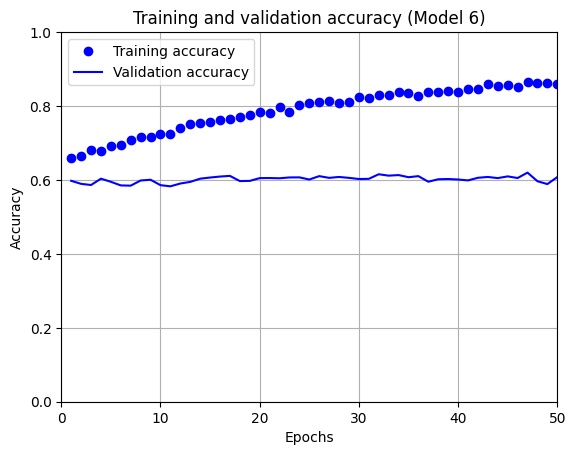

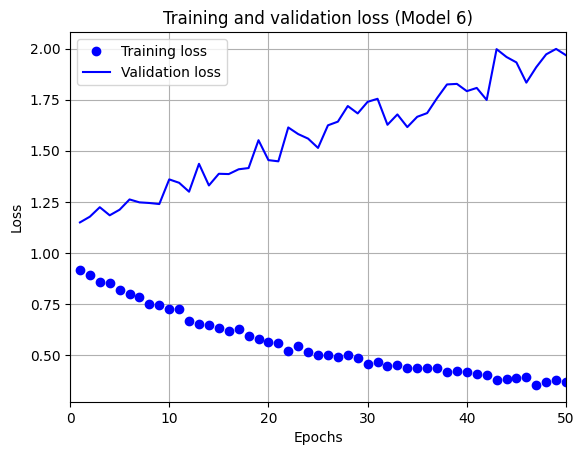

In [21]:
import matplotlib.pyplot as plt
acc10 = result10.history['accuracy']
val_acc10 = result10.history['val_accuracy']
loss10 = result10.history['loss']
val_loss10 = result10.history['val_loss']
epochs10 = range(1, len(acc10) + 1)

# Training and validation accuracy plot
plt.plot(epochs10, acc10, 'bo', label='Training accuracy')
plt.plot(epochs10, val_acc10, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (Model 6)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.ylim(0, 1)   # y축 범위 고정 (0 ~ 1)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()

# Training and validation loss plot
plt.plot(epochs10, loss10, 'bo', label='Training loss')
plt.plot(epochs10, val_loss10, 'b', label='Validation loss')
plt.title('Training and validation loss (Model 6)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()


